Recreation of https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [24]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch import save
from torch import load
from os import path

#import torch.utils.tensorboard as tb

from PIL import Image

from torchvision import datasets, models, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 
import random 
import os, math

import gc

import pdb
from skimage import io 

import matplotlib


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

Reproducibility

In [2]:
# Set manual seed.
def runRamdomSeed():
    torch.manual_seed(234)
    np.random.seed(234)
    random.seed(234)
    # Disabling the benchmarking feature with torch.backends.cudnn.benchmark = False 
    # causes cuDNN to deterministically select an algorithm, possibly at the cost of reduced performance.
    torch.backends.cudnn.benchmark = False 

runRamdomSeed()

First we need to import our data.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Then we need to establish how we will transform the data to fit into NN

In [4]:
unused_data_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

In [5]:

class OurDataset(Dataset):
    def __init__(self, csv_path, image_path, data_transforms=None):
        self.data_transforms = data_transforms
        self.image_path = image_path
        
        full_csv_frame = pd.read_csv(csv_path)
        csv_frame = full_csv_frame[["img_id", "city_id", "heading"]]
        
        self.pd_frame = csv_frame

        np_frame = csv_frame.to_numpy()

        

    def __len__(self):
        return self.pd_frame.iloc[:, 0].size


    def __getitem__(self, idx):
        image_path = self.image_path + "/" + str(self.pd_frame.iloc[idx, 0]).zfill(5) 
        img1 = Image.open(image_path + "_" + str( (self.pd_frame.iloc[idx, 2]) ).zfill(3) + ".jpg")
        img2 = Image.open(image_path + "_" + str( (self.pd_frame.iloc[idx, 2] + 120)%360 ).zfill(3) + ".jpg")
        img3 = Image.open(image_path + "_" + str( (self.pd_frame.iloc[idx, 2] + 240)%360 ).zfill(3) + ".jpg")
      
        img1 = torch.from_numpy(np.asarray(img1))     # convert to PyTorch Tensor
        img2 = torch.from_numpy(np.asarray(img2))  
        img3 = torch.from_numpy(np.asarray(img3)) 


        if self.data_transforms != None:
          img1 = self.data_transforms(img1)
          img2 = self.data_transforms(img2)
          img3 = self.data_transforms(img3)
        else:
          # Change from 640, 640, 3 to 3, 640, 640
          img1 = np.asarray(img1).transpose(-1, 0, 1)
          img2 = np.asarray(img2).transpose(-1, 0, 1)
          img3 = np.asarray(img3).transpose(-1, 0, 1)
        
        # img1 = torch.from_numpy(np.asarray(img1))     # convert to PyTorch Tensor (covered in transforms?)
        # img2 = torch.from_numpy(np.asarray(img2))     
        # img3 = torch.from_numpy(np.asarray(img3))     


        return (img1, img2, img3) , self.pd_frame.iloc[idx, 1]


Set Arguments

In [6]:
class Args(object):
    pass

args = Args();

args.learning_rate = .001
args.max_epochs = 1
args.batch_size = 64


Start by grabbing the already existing ResNet18 library

In [13]:
model_ft = models.resnet18(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False
    
num_ftrs = model_ft.fc.in_features
# resize last layer to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 10)

model_ft = model_ft.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [7]:
def save_model(model, name):
  if (path.exists(name + ".pth")): raise Exception("already exists")
  else: save(model.state_dict(), name + ".pth")


In [8]:
train_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_data.csv"
train_image_path = "/content/drive/Shareddrives/GeoTracking_AI/images"

train_dataset = OurDataset(train_csv_path, train_image_path, data_transforms=None)

trainloader = torch.utils.data.DataLoader(train_dataset, 
                                          batch_size = args.batch_size, 
                                          shuffle = True, 
                                          num_workers = 2)

valid_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_valid_data.csv"
valid_image_path = "/content/drive/Shareddrives/GeoTracking_AI/valid_images"

valid_dataset = OurDataset(valid_csv_path, valid_image_path, data_transforms=None)
validloader = torch.utils.data.DataLoader(valid_dataset, 
                                          batch_size = args.batch_size, 
                                          shuffle = True, 
                                          num_workers = 2)

Train new model

In [12]:
def train_model(args, model):
    if (path.exists(name + ".pth")): raise Exception("already exists")


    model = model.to(device) 

    #transform = transforms.Compose([transforms.ToTensor(),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
   
    #train_dataset = OurDataset(data_transforms=transform)
    #valid_dataset = OurDataset(data_transforms=transform)

    
    optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
    criterion = nn.CrossEntropyLoss()

    prev_val_acc = 0
    running_loss = 0.0
    best_val_acc = -1000
    for epoch in range(args.max_epochs):     # will get interupted by convergence test if validation acc drops
      for i, data in enumerate(trainloader, 0):
        outputs = []
        labels = 100

        for j in range(3):
          img = data[0][j]
          # get the inputs; data is a list of [inputs, labels]
          inputs, labels = img.to(device), data[1].to(device)

          #print("Input type: ", inputs.type())

          inputs = inputs.float()         # Broke our RAM (?)

          #print("Inputs floated")

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          # outputs = net(inputs)
          outputs.append(model(inputs))

        loss = criterion(np.sum(outputs)/3, labels)

        loss.backward()
        optimizer.step()

  
        running_loss += loss.item()

        del inputs, labels, loss        # added to reduce RAM issues
        gc.collect()

        # if i % 1000 == 999:    # print every 1000 mini-batches
        if i % 50 == 49:
            print('[%d, %5d] loss: %.3f' %(epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

    save_model(model, "/content/drive/Shareddrives/GeoTracking_AI/4_15_attempt0")

        
    print('Finished Training')

In [ ]:
model_ft = train_model(args, model_ft)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

KeyboardInterrupt: ignored

In [10]:
def accuracy_labels(preds, labels):
    return np.sum(preds == labels)/len(preds)

In [14]:
val_model = model_ft
val_dict = load("/content/drive/Shareddrives/GeoTracking_AI/4_16_28epoch_acc828.pth")
val_model.load_state_dict(val_dict)

<All keys matched successfully>

In [15]:
  # Test on Val set
  out_preds = []
  out_labels = []
  for (X,Y) in validloader:
    X = X[0].to(device)
    Y = Y.to(device)
    X = X.float()         # Broke our RAM (working at 64, not 256)
    y_pred = torch.argmax(val_model(X), dim = 1).tolist()
    print(y_pred)
    y_pred = map(int, y_pred)
    print(y_pred)
    out_preds.extend(list(y_pred))
    out_labels.extend(Y.tolist())
      
  this_val_acc = accuracy_labels(np.array(out_preds), np.array(out_labels))

  print('new_val_acc: %.3f'  %( this_val_acc))


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorc

[5, 7, 0, 0, 1, 1, 0, 1, 6, 6, 3, 1, 1, 7, 5, 6, 7, 7, 7, 3, 3, 4, 7, 8, 1, 0, 1, 0, 0, 3, 1, 0, 3, 0, 4, 5, 8, 7, 3, 7, 3, 7, 1, 4, 4, 5, 4, 4, 8, 3, 3, 3, 4, 1, 8, 0, 0, 1, 7, 4, 4, 5, 1, 5]
[5, 0, 7, 0, 4, 8, 0, 1, 6, 1, 6, 4, 0, 1, 3, 8, 8, 0, 6, 5, 1, 7, 8, 6, 1, 1, 0, 5, 4, 8, 0, 7, 0, 1, 3, 7, 5, 5, 0, 1, 4, 0, 4, 0, 4, 3, 3, 8, 3, 1, 4, 8, 1, 4, 3, 8, 1, 8, 0, 5, 1, 4, 7, 6]
[3, 7, 6, 3, 7, 3, 6, 7, 6, 3, 3, 7, 4, 7, 0, 1, 7, 1, 4, 4, 6, 4, 7, 5, 6, 4, 6, 1, 5, 0, 0, 0, 3, 1, 4, 8, 1, 1, 0, 5, 5, 3, 3, 5, 0, 1, 0, 3, 4, 1, 6, 7, 4, 7, 0, 1, 1, 5, 6, 3, 0, 5, 1, 4]
[4, 3, 0, 5, 0, 7, 7, 4, 8, 7, 4, 5, 6, 6, 4, 7, 1, 7, 8, 4, 6, 1, 5, 1, 0, 6, 7, 7, 7, 0, 0, 1, 0, 1, 7, 8, 4, 5, 0, 1, 6, 3, 8, 6, 1, 1, 3, 0, 3, 1, 4, 4, 3, 4, 1, 4, 6, 7, 4, 8, 3, 1, 7, 3]
[1, 1, 6, 4, 1, 4, 1, 7, 4, 0, 0, 1, 0, 3, 3, 7, 0, 0, 6, 1, 1, 5, 3, 0, 4, 3, 6, 0, 8, 5, 1, 3, 6, 4, 8, 0, 7, 3, 1, 6, 8, 1, 5, 6, 0, 0, 5, 6, 5, 7, 8, 6, 0, 8, 3, 1, 7, 3, 4, 0, 5, 5, 7, 4]
[4, 1, 8, 8, 1, 0, 1, 1, 0, 3, 7, 0

Checking accuracy for each city:

[Text(0, 0.5, 'City'),
 Text(0.5, 0, 'Percentage Correct'),
 Text(0.5, 1.0, 'Validation Accuracy by City')]

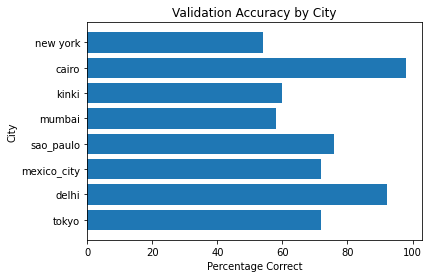

In [49]:
total = np.zeros(8)
correct = np.zeros(8)
city_labels = ['tokyo', 'delhi', 'mexico_city', 'sao_paulo', 'mumbai', 'kinki', 'cairo', 'new york']

for i in range(0,len(out_labels)):
  index = out_labels[i]

  if index > 2 and index < 9:
    index = index - 1

  total[index] = total[index] + 1

  if out_labels[i] == out_preds[i]:
    correct[index] = correct[index] + 1

percentages = 100*correct/total

fig, ax = plt.subplots()

ax.barh(city_labels,percentages)
ax.set(xlabel = 'Percentage Correct', ylabel = 'City', title = 'Validation Accuracy by City')

Visualization of outputs:

In [ ]:
    example_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_example_data.csv"
    example_image_path = "/content/drive/Shareddrives/GeoTracking_AI/example_images"
    
    # dataset = OurDataset(example_csv_path, example_image_path, data_transforms=None)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:26: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)


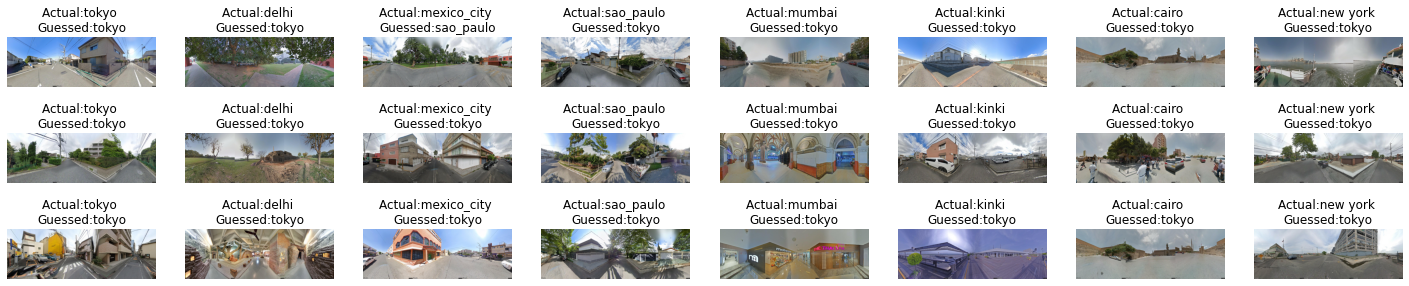

In [ ]:
# Note: modified from homework 4 given code

LABEL_ = ['tokyo', 'delhi', 'shanghai', 'mexico_city', 'sao_paulo', 'mumbai', 'kinki', 'cairo', 'new york', 'bejing']

def visualize_data():
    example_csv_path = "/content/drive/Shareddrives/GeoTracking_AI/image_example_data.csv"
    example_image_path = "/content/drive/Shareddrives/GeoTracking_AI/example_images"
    
    dataset = OurDataset(example_csv_path, example_image_path, data_transforms=None)
    loader = torch.utils.data.DataLoader(dataset, 
                                          batch_size = 1, 
                                          shuffle = True, 
                                          num_workers = 1)

    f, axes = plt.subplots(3, len(LABEL_)-2,figsize=(25,5))

    counts = [0]*(len(LABEL_)-2)

    # for imgs, label in dataset:
    for (i,data) in enumerate(loader,0):
    # for (i,data) in enumerate(trainloader,0):

        imgs = data[0]    # this part doesn't make sense to me (GMC 4/20) - shouldn't this be images for all the predicted values, not just 1 set of 3 images?

        # for loader:
        label = int(data[1].numpy())

        # for validloader (or trainloader):
        # labels = data[1].numpy()
        # label = int(data[1][0].numpy())

        this_label = int(label)


        if label > 2 and label != 9:
          this_label = this_label-1
        if label != 2 and label != 9:

          X = imgs[0].to(device)
          X = X.float()         # Broke our RAM (working at 64, not 256)
          y_pred = torch.argmax(val_model(X), dim = 1).tolist()
          y_pred_map = map(int, y_pred)

          

          c = counts[this_label]

          img = np.concatenate(imgs,axis=3)

          img = torch.from_numpy(img[0])

          if c < 3 :
              ax = axes[c][this_label]
              ax.imshow(img.permute(1, 2, 0).numpy())
              ax.axis('off')
              # ax.set_title(LABEL_[label])
              title = 'Actual:' + str(LABEL_[label]) + ' \nGuessed:' + str(LABEL_[y_pred[0]])
              ax.set_title(title)
              counts[this_label] += 1
          
          if sum(counts) >= 3 * len(LABEL_):
              print(counts)
              break

    plt.show()
    
visualize_data()

Report:

* Made our own dataset - DONE

* Transfer Model w/ One Image - Completed(ish) 4/15

* Transfer Model taking into account all 3 images - Spencer

* Hyper-parameter testing for Transfer Models

* Model from Scratch (do auto-tuning or hand-tune) - Zohar
  * Hyper-parameter testing
* Have one of two models work well (compared to human benchmark)

Write Report - 4/23-4/30

* Visualization that we can see images, their correct labels, model's guess for label - Greg
* Percentage correct for each city bar graph - Greg
* Need to justify:
  * ADAM?
  * Learning rate?
  * Choice of starting model for transfer model?
